In [1]:
%load_ext autoreload
%autoreload 2

In [64]:
import vaemof
from vaemof import experiments
from vaemof import utils
from vaemof.vocabs import SELFIESVocab, MOFVocab, PropVocab
from vaemof import modules
from vaemof import training
from vaemof.model import VAEMOF
from vaemof import configs

from vaemof.utils import header_str
vaemof.experiments.plot_settings()

In [63]:
import os
from tqdm.auto import tqdm
import numpy as np
import torch
import rdkit
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product
from collections import OrderedDict

print(f'rdkit : {rdkit.__version__}')
print(f'torch : {torch.__version__}')
print(f'cuda? {torch.cuda.is_available()}')
tqdm.pandas()
utils.disable_rdkit_log()

rdkit : 2019.09.3
torch : 1.4.0
cuda? True


/home/beangoben/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Hparams

In [4]:
preset = 'full'
WORK_DIR = 'results/test'
hparams = configs.get_model_config(WORK_DIR, preset, rand=False)
print(utils.header_str(preset))
hparams['train_device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

testing = configs.testing_config(hparams)
configs.print_config(hparams)
utils.set_seed(hparams['train_seed'])
device = torch.device(hparams['train_device'])

===================================== full =====================================
==================================== config ====================================
== train == :
        train_device:                cuda
          train_seed:                  42
    train_batch_size:                1536
        train_epochs:                  60
            train_lr:               0.005
     train_clip_grad:                  20
== vae == :
      vae_latent_dim:                 256
           vae_y_dec:                True
     vae_selfies_dec:                True
         vae_mof_enc:                True
         vae_mof_dec:                True
vae_duplicate_smiles:                True
== mof == :
        mof_encoding:                 all
   mof_weighted_loss:                True
         mof_w_start:                 0.0
           mof_w_end:                 1.0
           mof_start:                  15
    mof_const_length:                  10
== y == :
            y_labels:['lcd', 'pld'

## Load MOF data

Assemble smiles formula: [organic core][metal_node][topology][branch_smiles]

In [5]:
smiles_column = 'branch_smiles'
testtrain_column = 'train/test'
df = experiments.get_generator_df(csv_file=hparams['files_data'],
                                  smiles_column=smiles_column,
                                  use_duplicates=hparams['vae_duplicate_smiles'],
                                  testing=testing)
ids2mofs, mof2ids, mof_columns = experiments.get_mofdict(
    df, hparams['mof_encoding'])
df.head()

=================================== Real run ===================================
df shape: (2049964, 8)
df columns: ['branch_smiles', 'id2mof', 'metal_node', 'mof_index', 'organic_core', 'randomized', 'topology', 'train/test']
Found 713 unique mofs


,branch_smiles,id2mof,metal_node,mof_index,organic_core,randomized,topology,train/test
0,CC(c1cc(O)cc(O)c1)(C(Sc1cc(O)cc(O)c1)c1cc(O)cc...,0,sym_7_mc_4,4.0,None,False,acs,1
1,Oc1ccc(-c2cc(/C=C/c3c(-c4ccc(O)cc4)cc([Lr])c(-...,0,sym_7_mc_4,10.0,None,False,acs,1
2,O=S(=O)(O)Cc1nn([Lr])c(CS(=O)(=O)O)c1-c1c(CS(=...,0,sym_7_mc_4,18.0,None,False,acs,1
3,[Lr]c1ccc(-c2c(-c3ccccc3)cc([Lr])c(-c3ccccc3)c...,0,sym_7_mc_4,23.0,None,False,acs,1
4,[Lr]c1ccc(N2C=C(c3ccncc3)N(c3c(-c4ccncc4)cc([L...,0,sym_7_mc_4,29.0,None,False,acs,1


## Load property data

In [6]:
prop_df = experiments.get_prop_df(csv_file=hparams['files_prop'],
                                  targets=hparams['y_labels'],
                                  mof2ids=mof2ids,
                                  testing=testing,
                                  smiles_column=smiles_column,
                                  compute_scscore=True)
prop_df.head()

=================================== Real run ===================================
Restored variables from data/scscore_1024uint8_model.ckpt-10654.as_numpy.json.gz



Removed 2923 datapoints due to mask.
Removed 1819 datapoints due non-valid mof (mof2ids).
Removed 245 datapoints due to high selectivity.


,organic_core,metal_node,topology,branch_smiles,lcd,pld,density,avf,avsa,agsa,...,co2ch4_selectivity,co2ch4_heat_avg,co2ch4_heat_co2,co2ch4_heat_ch4,co2ch4_heat_molfrac,selfies_safe,mask,train/test,scscore,id2mof
0,None,sym_7_mc_4,acs,COc1c(/C=C/c2ccc([Lr])cc2)cc(OC)c(/C=C/c3ccc([...,24.87798,19.29733,0.164554,0.75459,1159.130,7044.060,...,1.786937,-8.58733,-12.08169,-7.92879,-8.61737,True,True,1,3.384814,0
1,None,sym_7_mc_4,acs,CSC1=C2CCC(=C(C(=C2SC)[Lr])SC)C(=C1[Lr])SC,7.78281,5.18969,1.119280,0.07631,978.891,874.575,...,3.197185,-20.54264,-24.18495,-18.74239,-20.17205,True,True,0,3.176298,0
2,None,sym_7_mc_4,acs,O=C(c1cc(O)c(cc1O)[Lr])OOC(=O)c1cc(O)c(cc1O)[Lr],17.01677,15.91720,0.320703,0.61736,1628.620,5078.290,...,3.004385,-11.22187,-16.39748,-9.43473,-11.17660,True,True,1,2.668208,0
3,None,sym_7_mc_4,acs,Oc1c(cc(c(c1O)[Lr])O)c1nnc(nn1)c1ccc(c(c1)O)[Lr],19.50569,17.17410,0.291374,0.66206,1401.740,4810.800,...,2.250807,-9.49245,-13.39225,-8.37161,-9.37550,True,True,1,3.688210,0
4,None,sym_7_mc_4,acs,[Lr]C12C=CC(C=C1)(C=C2)[Lr],9.58653,8.21739,0.799733,0.24196,2020.860,2526.910,...,2.167731,-15.36924,-18.34929,-14.67475,-15.38911,True,True,1,1.831772,0


## Train/test splits and hparams

In [7]:
train_index = np.array(df[df[testtrain_column] == 1].index.tolist())
test_index = np.array(df[df[testtrain_column] == 0].index.tolist())
prop_train_index = np.array(
    prop_df[prop_df[testtrain_column] == 1].index.tolist())
prop_test_index = np.array(
    prop_df[prop_df[testtrain_column] == 0].index.tolist())
print(f'Train sizes: {len(train_index):7d} and {len(prop_train_index):7d}')
print(f'Test  sizes: {len(test_index):7d} and {len(prop_test_index):7d}')

Train sizes: 1894967 and   36795
Test  sizes:  154997 and    4107


# Vocabulary and preprocessors

In [8]:
smiles_list = df[smiles_column].tolist()+prop_df[smiles_column].tolist()
vocab = SELFIESVocab.from_data(smiles_list)
vocab_mof = MOFVocab.from_data(df.append(
    prop_df, sort=False), mof_columns, weighting=hparams['mof_weighted_loss'])
vocab_y = PropVocab.from_data(
    prop_df, hparams['y_labels'], hparams['y_weights'])
vocab, vocab_mof, vocab_y


Alphabet size is 73
Max seq length is 109 with 5 extra padding
Used columns =['metal_node', 'organic_core', 'topology', 'id2mof'] with frequency weighting=True
metal_node   has 15 classes
organic_core has 52 classes
topology     has 41 classes
id2mof       has 713 classes


(<vaemof.vocabs.SELFIESVocab at 0x7f81780b9d90>,
 <vaemof.vocabs.PropVocab at 0x7f826c578c10>)

# Instanciate Model

## Careful! (it saves and will overwrite any model previously saved)

In [38]:
try:
    utils.clear_torch(model)
except:
    utils.clear_torch(model=None)

model = VAEMOF(hparams, vocab, vocab_mof, vocab_y).to(device)
model.save()
modules.model_summary(model, include_children=False)

,Name,Module,Extra,submodule,trainable,n_params,trainable_params
0,z_mu,Linear,"in_features=512, out_features=256, bias=True",False,True,131328,131328
1,z_logvar,Linear,"in_features=512, out_features=256, bias=True",False,True,131328,131328
2,enc_x,CharEncoder,,False,True,390208,390208
3,dec_x,CharDecoder,,False,True,1467016,1467016
4,enc_mof,MOFEncoder,,False,True,407552,407552
5,dec_mof,MOFDecoder,,False,True,277610,276789
6,dec_y,PropDecoder,,False,True,5418,5397


Trainable params: 2804434 out of 2805276 total (99.97%)


## Prepare train/test 

In [33]:
train_mof = model.df_to_tuples(df.loc[train_index], smiles_column)
test_mof = model.df_to_tuples(df.loc[test_index], smiles_column)
prop_train = model.df_to_tuples(prop_df.loc[prop_train_index], smiles_column)
prop_test = model.df_to_tuples(prop_df.loc[prop_test_index], smiles_column)
train_data = train_mof + prop_train
test_data = test_mof + prop_test

## Train

In [40]:
trainer = training.Trainer(hparams)
trainer.train(model, train_data[-2000:], test_data[-2000:])

# Results
## Load saved model

In [41]:
hparams_file = os.path.join(WORK_DIR,'config.json')
hparams = configs.AttributeDict.from_jsonfile(hparams_file)
model = VAEMOF.load(hparams)

## Training stats

In [42]:
log_df = pd.read_csv(configs.at_results_dir(hparams,'files_log'))
print(log_df.shape)
print(log_df.columns)
log_df.head()

(60, 69)
Index(['epoch', 'test_kl', 'test_x', 'test_mof', 'test_y', 'test_loss',
       'lcd-r2', 'lcd-MAE', 'pld-r2', 'pld-MAE', 'density-r2', 'density-MAE',
       'avf-r2', 'avf-MAE', 'avsa-r2', 'avsa-MAE', 'agsa-r2', 'agsa-MAE',
       'co2n2_co2_mol_kg-r2', 'co2n2_co2_mol_kg-MAE', 'co2n2_n2_mol_kg-r2',
       'co2n2_n2_mol_kg-MAE', 'co2n2_selectivity-r2', 'co2n2_selectivity-MAE',
       'co2n2_heat_avg-r2', 'co2n2_heat_avg-MAE', 'co2n2_heat_co2-r2',
       'co2n2_heat_co2-MAE', 'co2n2_heat_n2-r2', 'co2n2_heat_n2-MAE',
       'co2n2_heat_molfrac-r2', 'co2n2_heat_molfrac-MAE',
       'co2ch4_co2_mol_kg-r2', 'co2ch4_co2_mol_kg-MAE', 'co2ch4_ch4_mol_kg-r2',
       'co2ch4_ch4_mol_kg-MAE', 'co2ch4_selectivity-r2',
       'co2ch4_selectivity-MAE', 'co2ch4_heat_avg-r2', 'co2ch4_heat_avg-MAE',
       'co2ch4_heat_co2-r2', 'co2ch4_heat_co2-MAE', 'co2ch4_heat_ch4-r2',
       'co2ch4_heat_ch4-MAE', 'co2ch4_heat_molfrac-r2',
       'co2ch4_heat_molfrac-MAE', 'scscore-r2', 'scscore-MAE', 'lr',

,epoch,test_kl,test_x,test_mof,test_y,test_loss,lcd-r2,lcd-MAE,pld-r2,pld-MAE,...,mof_acc,mean_r2,train_kl_ratio,train_x_ratio,train_mof_ratio,train_y_ratio,test_kl_ratio,test_x_ratio,test_mof_ratio,test_y_ratio
0,0,94.523010,7.469648,17.164950,37.741392,7.470593,0.987277,43.551884,0.754730,178.632111,...,4.7125,0.586427,0.000694,0.999306,0.0,0.0,0.000127,0.999873,0.0,0.0
1,1,4.702600,4.203964,17.040815,30.916170,4.445408,0.989709,40.507927,0.883721,130.827316,...,2.8250,0.823466,0.367640,0.632360,0.0,0.0,0.054313,0.945687,0.0,0.0
2,2,2.482859,4.462470,17.037380,31.151827,4.717398,0.954007,84.543083,0.983874,57.126289,...,2.9250,0.697840,0.068804,0.931196,0.0,0.0,0.054040,0.945960,0.0,0.0
3,3,0.658658,4.194001,17.044577,31.122787,4.295440,0.995617,27.787924,0.879505,127.698303,...,3.3125,0.775279,0.060475,0.939525,0.0,0.0,0.023615,0.976385,0.0,0.0
4,4,1.121940,3.836405,17.055120,31.274247,4.066785,0.996464,24.681618,0.936312,112.138252,...,3.5750,0.880550,0.017608,0.982392,0.0,0.0,0.056649,0.943351,0.0,0.0


,epoch,test_kl,test_x,test_mof,test_y,test_loss,lcd-r2,lcd-MAE,pld-r2,pld-MAE,...,mof_acc,mean_r2,train_kl_ratio,train_x_ratio,train_mof_ratio,train_y_ratio,test_kl_ratio,test_x_ratio,test_mof_ratio,test_y_ratio
0,0,94.52301,7.469648,17.164950,37.741392,7.470593,0.987277,43.551884,0.754730,178.632111,...,4.7125,0.586427,0.000694,0.999306,0.0,0.0,0.000127,0.999873,0.0,0.0
1,1,4.70260,4.203964,17.040815,30.916170,4.445408,0.989709,40.507927,0.883721,130.827316,...,2.8250,0.823466,0.367640,0.632360,0.0,0.0,0.054313,0.945687,0.0,0.0


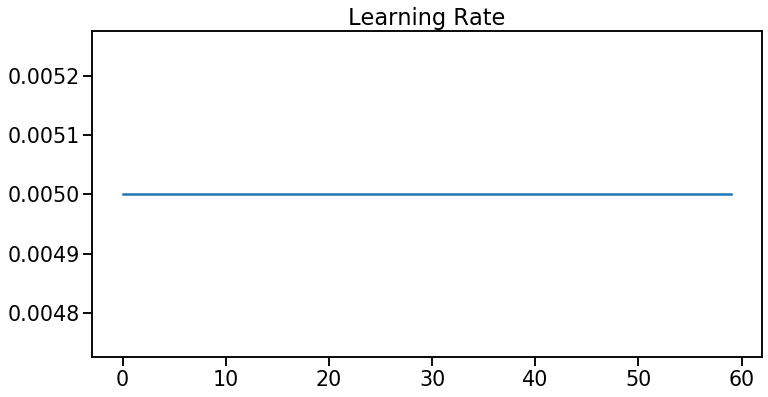

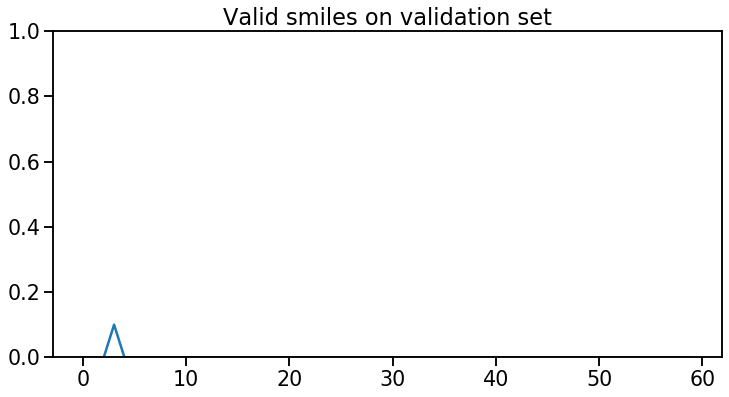

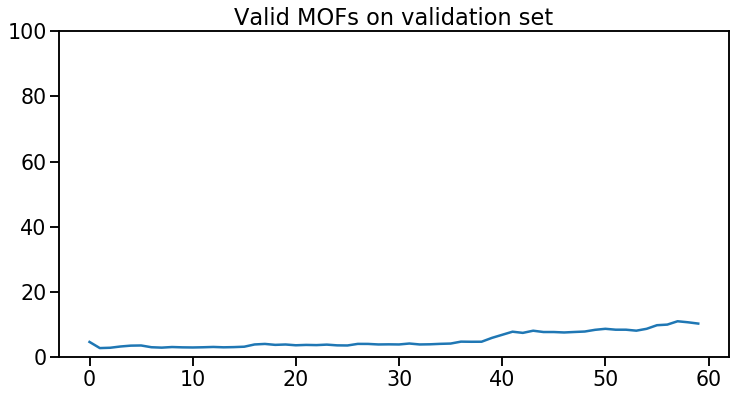

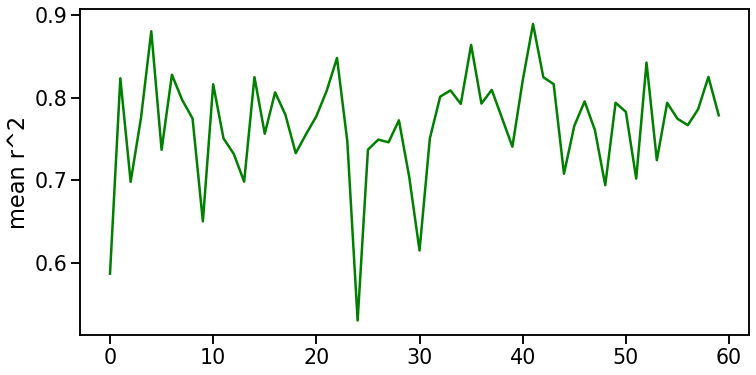

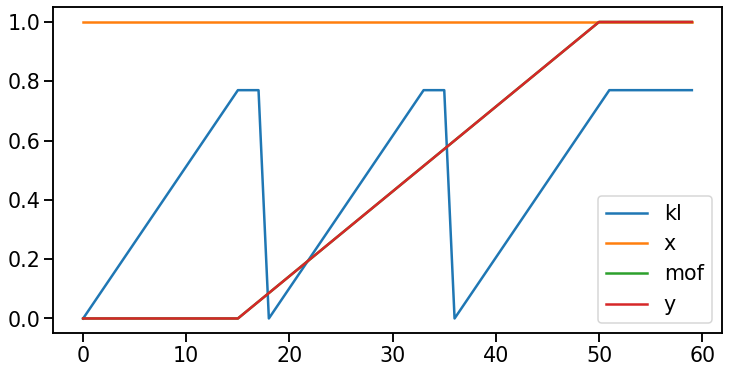

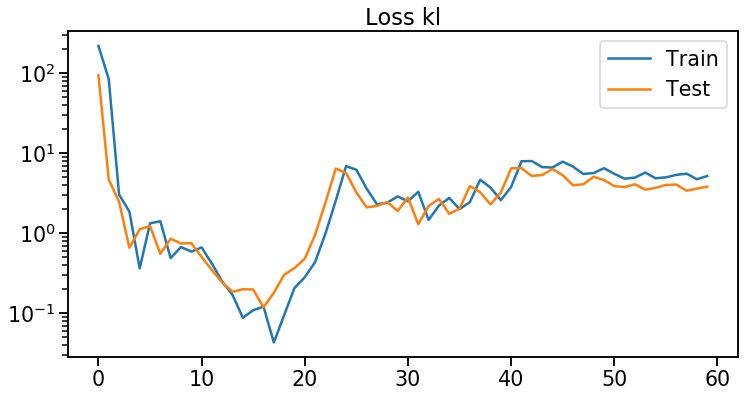

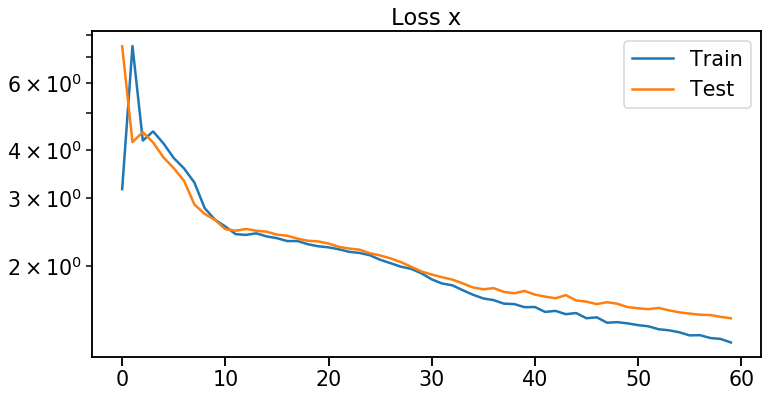

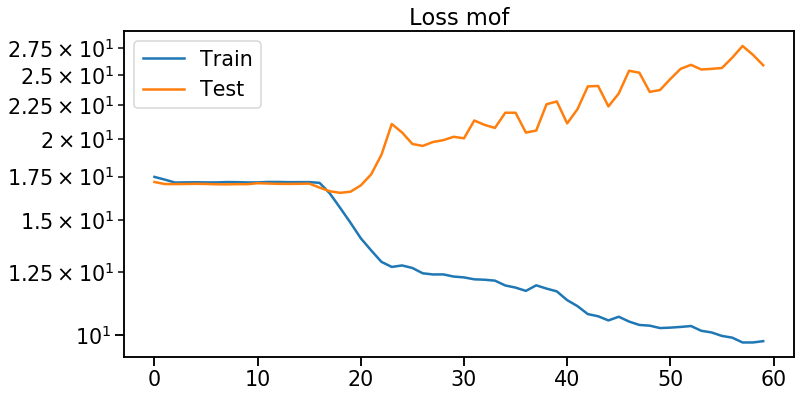

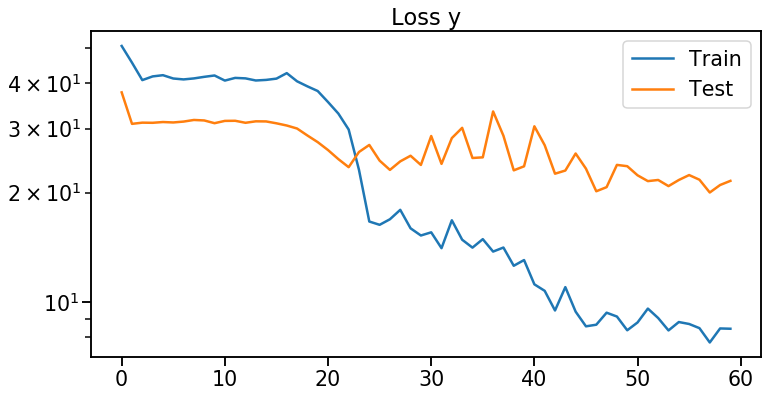

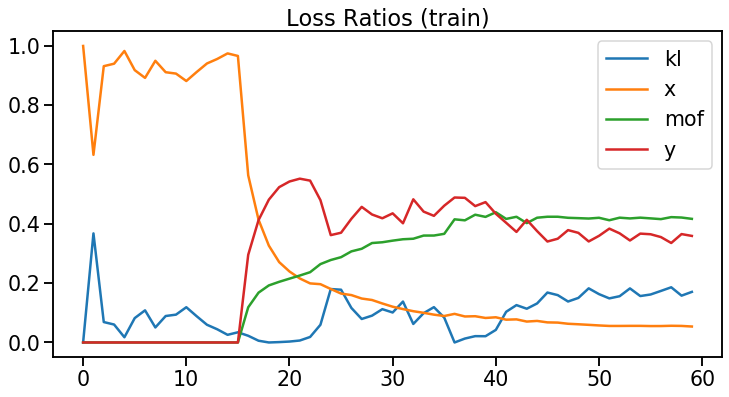

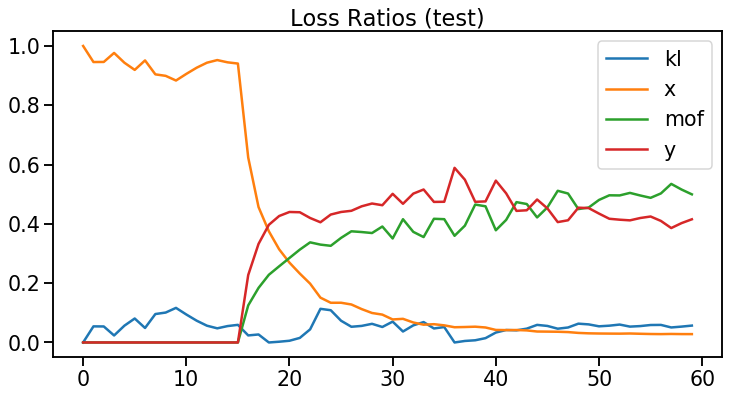

In [46]:
COMPONENTS = training.COMPONENTS
epochs = log_df['epoch'].values

display(log_df.head(2))
plt.plot(epochs, log_df['lr'])
plt.title('Learning Rate')
plt.show()

plt.plot(epochs, log_df['valid_smiles'])
plt.title('Valid smiles on validation set')
plt.ylim([0,1])
plt.show()

plt.plot(epochs, log_df['mof_acc'])
plt.title('Valid MOFs on validation set')
plt.ylim([0,100])
plt.show()

plt.plot(epochs, log_df['mean_r2'],c='g',label='valid')
plt.ylabel('mean r^2')
plt.show()

results=[]
for label in hparams['y_labels']:
    metric = f'{label}-r2'
    results.extend([{'epoch':epoch,'r2':value,"prop":label} for epoch, value in log_df[['epoch',metric]].values ]  )
prop_df = pd.DataFrame(results)
sns.lineplot(x='epoch',y='r2', data=prop_df)
plt.show()

for label in COMPONENTS:
    plt.plot(epochs, log_df[f'λ_{label}'], label =label)
plt.legend()
plt.show()

for label in COMPONENTS:
    plt.plot(epochs, log_df[f'train_{label}'], label='Train')
    plt.plot(epochs, log_df[f'test_{label}'], label='Test')
    plt.title(f'Loss {label}')
    plt.yscale("log")
    plt.legend()
    plt.show()

for prefix in ['train','test']:
    for label in COMPONENTS:
        plt.plot(epochs, log_df[f'{prefix}_{label}_ratio'], label=label) 
    plt.title(f'Loss Ratios ({prefix})')
    plt.legend()
    plt.show()

## Load saved model

In [53]:
with open(os.path.join(hparams['files_results'],config.config_save),'r') as afile:
    config = json.load(afile, object_pairs_hook=models.utils.AttributeDict)

vocab = torch.load(os.path.join(hparams['files_results'], config.vocab_save))
vocab_mof = torch.load(os.path.join(hparams['files_results'], 'mof'))
y_scaler = torch.load(os.path.join(hparams['files_results'], 'y_scaler'))
model_state = torch.load(os.path.join(hparams['files_results'], config.model_save))

model = VAEMOF(vocab, mof_vocab,y_scaler,config).to(device)
model.load_state_dict(model_state)
model = model.to(device)
model.eval()

NameError: name 'config' is not defined

In [ ]:
print(header_str('Losses'))
log_file = os.path.join(hparams['files_results'],config['log_file'])
log_df = pd.read_csv(log_file)
eval_row = log_df.query('mode=="Eval"').iloc[-1]
train_row = log_df.query('mode=="Train"').iloc[-1]
for label in ['kl_','recon_','mof_','y_']+['']:
    min_train = np.min(train_row[label+'loss'])
    min_valid = np.max(eval_row[label+'loss'])
    print('{:6s}loss = {:.3e} / {:.3e}'.format(label,min_train,min_valid))

In [ ]:
sub_sample = 10000
src_data = prop_test
#src_data = random.sample(src_data,min(len(src_data),sub_sample))

predict_properties

n = len(src_data)
batch_size=64
n_loops = int(np.ceil(n/batch_size))
z=[]
y_true=[]
y_pred=[]
with torch.no_grad():
    for chunk in  tqdm(models.utils.chunks(src_data,batch_size),total=n_loops, desc='Generating predictions'):
        x_tensor,mof_tensor,y_tensor,y_mask = trainer.get_collate_fn(model)(chunk)
        _, z_tensor = model.forward_encoder(x_tensor,mof_tensor)
        y_pred_tensor = model.z_to_y(z_tensor)
        z.extend(z_tensor.cpu().numpy())
        y_pred.extend(y_pred_tensor.cpu().numpy())
        y_true.extend(y_tensor.cpu().numpy())
        
z = np.stack(z)
y_true = np.stack(y_true)
y_pred = np.stack(y_pred)
z_pca = PCA(2).fit_transform(z)
z_df = pd.DataFrame()
for index,col in enumerate(targets):
    z_df[col]=y_true[:,index]
    z_df[col+'_pred']=y_pred[:,index]
    r2 = sklearn.metrics.r2_score(y_true[:,index],y_pred[:,index])
    mae = sklearn.metrics.mean_absolute_error(y_true[:,index],y_pred[:,index])
    print('{:20} -> r^2= {:3f}, MAE= {:.3f}'.format(col,r2,mae))
z_df['x']=z_pca[:,0]
z_df['y']=z_pca[:,1]
print(z.shape)

## Prior check

In [ ]:
print(header_str('prior'))
samples = []
n = 1024
batch_size=64
n_loops = int(np.ceil(n/batch_size))
for chunk in  tqdm(models.utils.chunks(list(range(n)),batch_size),total=n_loops, desc='Generating samples'):
    n_batch = min(len(chunk), batch_size)
    z = model.sample_z_prior(n_batch)
    smiles_list = model.sample(n_batch, config.max_length,z=z)
    mof_list = model.z_to_mof(z)
    samples.extend([ [smi]+mof for smi,mof in zip(smiles_list,mof_list)])
    
gen_df = pd.DataFrame(samples,columns=[smiles_column]+mof_columns)
gen_df['valid'] = gen_df[smiles_column].apply(models.utils.valid_smiles)
print('valid smiles: {} out of {} ({}%)'.format(gen_df['valid'].sum(),n,gen_df['valid'].sum()/n*100.0))

gen_df

## Posterior check

In [ ]:
print(header_str('Posterior check'))

tries=2
sub_sample =1000
src_data = train_data
src_data = random.sample(src_data,min(len(src_data),sub_sample))
valid_smiles=[]
recon_smiles=[]
n = len(src_data)
results=[]
mof_results=[]
print(n)
with torch.no_grad():
    for t in tqdm(src_data):
        batch = [t]*tries
        true_smiles = isosmiles(vocab.ids2string(t[0]))
        true_mof = mof_vocab.ids2mof(t[1])
        x_tensor,mof,y,y_mask = trainer.get_collate_fn(model)(batch)
        _, z_tensor = model.forward_encoder(x_tensor,mof)
        mof_list = np.array(model.z_to_mof(z_tensor))
        pred_mof = [mof_list[:,i].tolist() for i in range(3)]
        acc_mof = any([ all(i==true_mof) for i in mof_list])
        _, x_recon_tensor = model.forward_x_decoder(x_tensor,z_tensor)
        re_smiles = [model.tensor2string(x_i) for x_i in x_recon_tensor]
        valid_smiles = [si for si in set(re_smiles) if models.utils.valid_smiles(si)]
        valid_smiles = [isosmiles(si) for si in valid_smiles]
        same_smiles = [si for si in valid_smiles if si==true_smiles]
        results.append([true_smiles, re_smiles[0], len(same_smiles)>0,len(valid_smiles)>0])
        mof_results.append(acc_mof)

        
post_df = pd.DataFrame(results,columns=['smiles','recon_smiles','same','valid'])
print('valid: {} out of {} ({:.2f}%)'.format(post_df['valid'].sum(),n,post_df['valid'].sum()/n*100.0))
print('same : {} out of {} ({:.2f}%)'.format(post_df['same'].sum(),n,post_df['same'].sum()/n*100.0))
display(post_df.head(1))
print('Mof recon acc: {}'.format(float(sum(mof_results))/float(len(mof_results))))

In [ ]:
sub_sample = 10000
src_data = train_data
src_data = random.sample(src_data,min(len(src_data),sub_sample))
n = len(src_data)
batch_size=64
n_loops = int(np.ceil(n/batch_size))
z=[]
mof=[]
mof_ids=[]
with torch.no_grad():
    for chunk in  tqdm(models.utils.chunks(src_data,batch_size),total=n_loops, desc='Generating samples'):
        mof.extend([mof_vocab.ids2mof(t[1]) for t in chunk])
        x_tensor,mof_tensor,y, y_mask = trainer.get_collate_fn(model)(chunk)
        _, z_tensor = model.forward_encoder(x_tensor,mof_tensor)
        z.extend(z_tensor.cpu().numpy())
        mof_ids.extend([mof_vocab.ids2mof(t) for t in mof_tensor.cpu().numpy()])
        
z = np.stack(z)
z_pca = PCA(2).fit_transform(z)
z_df = pd.DataFrame(mof,columns=mof_columns)
z_df['x']=z_pca[:,0]
z_df['y']=z_pca[:,1]
mof_ids = np.stack(mof_ids)
print(z.shape,mof_ids.shape)

In [ ]:
top_k=8
for index,col in enumerate(mof_columns):
    print(models.utils.header_str(col))
    plt.figure(figsize=(8,8))
    top_cat = z_df[col].value_counts(sort=True).iloc[:top_k].index.tolist()
    sns.scatterplot(x='x',y='y',hue=col,s=20,data=z_df[z_df[col].isin(top_cat)])
    plt.legend(bbox_to_anchor=(1.0, .5))
    plt.title(col)
    plt.show()